In [1]:
import graph_tool.all as gt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py # management and storage of large datasets
import os
import shutil
from scipy.stats import poisson
import json
import time
from datetime import datetime
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys
import logging
# Clear any existing loggers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set up logging to overwrite the log.txt file on every run
logging.basicConfig(filename="log.txt", level=logging.INFO, 
                    format="%(asctime)s - %(levelname)s - %(message)s", filemode='w')


## Utility functions

In [3]:
class GraphIO:
    """ A class for imput and output operations on graphs and their metadata
    Attributes:
        base_dir: the parent directory of the experiment
        header_file: txt file containing a short description of the characteristic of the graphs used in the experiment
    
    Methods:
        save_graph()
        save_inferred_graph()
        save_graph_metadata()
        save_dyn_metadata()
        load_metadata()
        filter_graphs()
    """

    def __init__(self, experiment_name, header_file):
        self.experiment_name = experiment_name
        os.makedirs(experiment_name, exist_ok=True)
        self.base_dir = os.path.join(experiment_name, 'graphs')
        os.makedirs(self.base_dir, exist_ok=True)
        self.results_dir = os.path.join('results', experiment_name)
        os.makedirs(self.results_dir, exist_ok=True)
        header_path = os.path.join(experiment_name, 'header.txt')
        if os.path.exists(header_path):
            return
        with open(header_path, "w") as f:
            f.write(header_file)

    def save_graph(self, g: gt.Graph):
        """
        Saves graph in the smallest unused directory within parent directory self.base_dir
        """
        #get the smallest unused index
        existing_dirs = [d for d in os.listdir(self.base_dir) if os.path.isdir(os.path.join(self.base_dir, d))]
        existing_indices = []
        for d in existing_dirs:
            if d.startswith('graph_'):
                try:
                    index = int(d.split('_')[1])
                    existing_indices.append(index)
                except (IndexError, ValueError):
                    continue
        if existing_indices:
            graph_id = min(set(range(1, max(existing_indices) + 2)) - set(existing_indices))
        else:
            graph_id = 1
        #create folder and save
        graph_dir = os.path.join(self.base_dir, f'graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        output_path = os.path.join(graph_dir, 'graph.gt')
        g.save(output_path)
        return graph_id

    def save_graph_metadata(self, graph_id, metadata):
        graph_dir = os.path.join(self.base_dir, f'graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        metadata_path = os.path.join(graph_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load_metadata(self, dir):
        metadata_path = os.path.join(dir, 'metadata.json')
        with open(metadata_path, 'r') as f:
            return json.load(f)

    # Save dynamics metadata
    def save_dyn_metadata(self, metadata: dict, out_dir: str):
        metadata_path = os.path.join(out_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    # Save inferred graph
    def save_inferred_graph(self, g: gt.Graph, dyn_dir_path: str):
        #get the smallest unused index
        existing_dirs = [d for d in os.listdir(dyn_dir_path) if os.path.isdir(os.path.join(dyn_dir_path, d))]
        existing_indices = []
        for d in existing_dirs:
            if d.startswith('inferred_graph_'):
                try:
                    index = int(d.split('_')[2])
                    existing_indices.append(index)
                except (IndexError, ValueError):
                    continue
        if existing_indices:
            graph_id = min(set(range(1, max(existing_indices) + 2)) - set(existing_indices))
        else:
            graph_id = 1
        #create folder and save
        graph_dir = os.path.join(dyn_dir_path, f'inferred_graph_{graph_id}')
        os.makedirs(graph_dir, exist_ok=True)
        output_path = os.path.join(graph_dir, 'graph.gt')
        g.save(output_path)
        return graph_id

    @staticmethod
    def list_directories(parent_dir)-> list:
        directories = []
        for item in os.listdir(parent_dir):
            item_path = os.path.join(parent_dir, item)
            if os.path.isdir(item_path):
                directories.append(item)
        return directories
    
    
    def filter_graphs(self,  nodes: int = None, creation_date: str = None) -> list:
        #return selected graph folder paths
        selected_graphs = []
        for graph_folder in GraphIO.list_directories(self.base_dir):
            graph_path = os.path.join(self.base_dir, graph_folder)
            if os.path.isdir(graph_path):
                metadata = self.load_metadata(graph_path)
                graph_nodes = metadata.get('nodes', None)
                graph_creation_date = metadata.get('creation_date', "XXXX-XX-XXTXX:XX:XX.XXXXX")
                if nodes and nodes != graph_nodes:
                    continue #discard current folder
                if creation_date and isinstance(creation_date, str):
                    #Look at day only
                    # Creation time is in format 2024-09-30T17:47:17.997948
                    if creation_date != graph_creation_date.split('T')[0]:
                        continue
                selected_graphs.append(graph_folder)
        return selected_graphs

class GraphGeneration:
    """
    A class of customized functions for graph generation
    Builts on modules of graph-tool.generation.

    (@staticmethod decorator in Python is used to define a method within a class
    that doesn’t require access to the instance (self) or class (cls) in which
    it’s defined. In other words, a static method is a function that belongs
    to the class, but it doesn’t need to access or modify any instance or 
    class-level attributes. It’s just logically grouped with the class because
    it’s relevant to the class’s functionality. 
    A static method can be called using the class name or an instance of the class)
    """
    @staticmethod
    def poisson_(mu = 5):
        return poisson.rvs(mu)
    ## 1/sqrt(k)
    @staticmethod
    def k_05(kmax = 20):
        accept = False
        while not accept:
            k = np.random.randint(1,kmax+1)
            accept = np.random.random() < 1.0/np.sqrt(k)
        return k
    ## 1/k
    @staticmethod
    def k_1(kmax = 20):
        accept = False
        while not accept:
            k = np.random.randint(1,kmax+1)
            accept = np.random.random() < 1.0/k
        return k
    # SBM
    @staticmethod
    def prob(a, b):
        if a == b:
            return 0.999
        else:
            return 0.001
    @staticmethod
    def sample_sbm(size: int, k: int = 4) -> gt.Graph:
        partitions = np.floor(np.float_power(size, 1./3))
        g, bm = gt.random_graph(size,
                                lambda: GraphGeneration.poisson_(k),
                                directed=False,
                                model="blockmodel",
                                block_membership=lambda: np.random.randint(partitions),
                                edge_probs=GraphGeneration.prob)
        gt.remove_parallel_edges(g)
        gt.remove_self_loops(g)
        return g,bm
    
    # undirected assortative graph (edge is favoured between nodes of similar degree)
    #g = gt.random_graph(1000, lambda: k_1(40), model="probabilistic-configuration",
    #                    edge_probs=lambda i, k: 1.0 / (1 + abs(i - k))**(1/4), directed=False,
    #                    n_iter=100)
    # undirected disassortative graph (edge is favoured between nodes of different degree)
    #g = gt.random_graph(1000, lambda: k_05(40), model="probabilistic-configuration",
    #                    edge_probs=lambda i, k: (1 + abs(i - k)), directed=False,
    #                    n_iter=100)
    #gt.random_rewire(g, model= 'erdos', n_iter= 1)
    
class GraphVisualization:
    """
    A class of methods for basic inspection of graphs
    """
    @staticmethod
    def degree_distribution_plot(g:gt.Graph) ->None:
        degrees = [v.out_degree() for v in g.vertices()]
        unique_degrees, counts = np.unique(degrees, return_counts=True)
        prob_dist = counts / counts.sum()
        plt.figure(figsize=(8, 6))
        plt.plot(unique_degrees, prob_dist, marker='o', linestyle='None', markersize=5, color='b')
        plt.title('Degree Distribution (log-log scale)')
        plt.xlabel('Degree')
        plt.ylabel('Probability')
        plt.grid(True)
        plt.show()

    @staticmethod
    def correlation_plot(g:gt.Graph) -> None:
        plt.figure(figsize=(8,3))
        corr = gt.avg_neighbor_corr(g, "total", "total")
        plt.errorbar(corr[2][:-1], corr[0], yerr=corr[1], fmt="o-",label=r"<k n.n.> vs k")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

# Experiment definition

In [4]:
current_datetime = datetime.now()
header = f"""
    creation date: {current_datetime}
    This folder contains all the data for a performance evaluation of the inference algorithm.
    The algorithm is tested using input data generated from simulated Ising-Glauber dynamics.
    The graphs used in this test are synthetic, undirected, and free of self-loops and multi-edges.
    They are generated from a Stochastic Block Model (SBM) with  N  nodes and approximately  N^{1/3}  partitions.
    The probability of intra-partition connections is 0.999, while the probability of inter-partition connections is 0.001.
    This structure results in partitions that are highly likely to form disjoint connected components.
    The mean degree is set to k_mean = 4.
    The Ising dynamics is simulated for a fixed value of the inverse temperature beta = 1.
    The graphs is given uniform weights = 1/ k_mean. This combination of weights and inverse temperature
    results in a partially ordered regime for the Ising dynamics, thus enabling inference.
"""
giom = GraphIO(experiment_name= 'experiment_small_graphs', header_file= header)

## Graph generation (SBM)

In [5]:
def define_metadata(g: gt.Graph) -> dict:
    k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
    current_datetime = datetime.now()
    metadata = {
        "graph_type": "SBM",
        "nodes": g.num_vertices(),
        "edges": g.num_edges(),
        "directed": "false",
        "degree_distribution": "poisson",
        "power_law_exponent": "null",
        "mean_degree": k_mean,
        "edge_density": 2 * g.num_edges() / (g.num_vertices() ** 2),
        "correlations": "false",
        "weight": 1 / k_mean,
        "creation_date": current_datetime.isoformat()
    }
    return metadata


graph_sizes = [n * 5 for n in range(2, 20)]

for size in graph_sizes:
    g,bm = GraphGeneration.sample_sbm(size = size)
    k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
    w = g.new_edge_property("double", vals= [1./k_mean])
    g.ep["weights"] = w
    idx = giom.save_graph(g)
    gt.graph_draw(g, vertex_fill_color = bm, output=os.path.join(giom.base_dir, f'graph_{idx}', 'visualization.pdf'))
    giom.save_graph_metadata(graph_id=idx, metadata = define_metadata(g))

In [44]:
# Check how many graphs are in the dataset for each number of nodes
folders = giom.list_directories(parent_dir= giom.base_dir)
nodes = []
for folder in folders:
    metadata = giom.load_metadata(os.path.join(giom.base_dir, folder))
    nodes.append(metadata['nodes'])
nodes = np.array(nodes)
unique_nodes = np.unique(nodes)
node_counts = [np.sum(nodes == n) for n in unique_nodes]
# make a dictionary
dict = {unique_nodes[i]: node_counts[i] for i in range(len(unique_nodes))}
for key in dict:
    print(f"{key} nodes: {dict[key]} graphs")

10 nodes: 40 graphs
15 nodes: 40 graphs
20 nodes: 40 graphs
25 nodes: 40 graphs
30 nodes: 40 graphs
35 nodes: 40 graphs
40 nodes: 40 graphs
45 nodes: 40 graphs
50 nodes: 40 graphs
55 nodes: 40 graphs
60 nodes: 40 graphs
65 nodes: 40 graphs
70 nodes: 40 graphs
75 nodes: 40 graphs
80 nodes: 40 graphs
85 nodes: 40 graphs
90 nodes: 40 graphs
95 nodes: 40 graphs


## Dynamics generation

In [7]:
dynamics_name = 'IsingGlauber'
M = 1000
# If True, overwrite existing dynamics and deletes all infered graphs with old dynamics
# If False, skip graphs with existing dynamics
overwrite = False

graph_folders = giom.list_directories(giom.base_dir)

if graph_folders:
    for i, graph_folder in enumerate(graph_folders):
        dyn_folder_path = os.path.join(giom.base_dir, graph_folder, dynamics_name)
        existing = os.path.exists(dyn_folder_path) and os.path.isdir(dyn_folder_path)
        if existing and not overwrite:
            print(f"skipping graph {graph_folder}")
            continue
        if existing and overwrite:
            shutil.rmtree(dyn_folder_path)
            print(f"overwriting graph {graph_folder}")


        input_path = os.path.join(giom.base_dir, graph_folder, 'graph.gt')
        g_new = gt.load_graph(input_path)
        k_mean = sum(g_new.degree_property_map("total").a)/ g_new.num_vertices()
        
        start_time = time.time()
        istate = gt.IsingGlauberState(g_new, w= 1./k_mean)
        X = []
        for m in range(M):
            istate.iterate_sync()
            X.append(istate.get_state().a.copy())
        X = np.array(X).T # N rows, M columns
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"simulated dynamics {X.shape} in : {execution_time} seconds")

        all_valid_values = np.isfinite(X).all()
        if not all_valid_values:
            print("Invalid values. Dynamics not saved. Continue to next graph")
            continue

        # Save
        os.makedirs(dyn_folder_path, exist_ok=True)
        output_path = os.path.join(dyn_folder_path, 'dynamics.h5')
        with h5py.File(output_path, 'w') as hf:
            hf.create_dataset('dataset_name', data=X)
        current_datetime = datetime.now()
        metadata = {
            'dynamics': dynamics_name,
            'nodes': g_new.num_vertices(),
            'samples': M,
            'execution_time': execution_time,
            'weights': 1./k_mean,
            'beta': 1,
            'h': 0,
            'initial_state': 'random',
            'creation_date': current_datetime.strftime("%d-%m-%Y/%H:%M:%S")
        }
        giom.save_dyn_metadata(metadata= metadata, out_dir= dyn_folder_path)   

skipping graph graph_168
skipping graph graph_14
skipping graph graph_365
skipping graph graph_157
skipping graph graph_533
skipping graph graph_701
skipping graph graph_391
skipping graph graph_13
skipping graph graph_396
skipping graph graph_706
skipping graph graph_534
skipping graph graph_150
skipping graph graph_362
skipping graph graph_25
skipping graph graph_159
skipping graph graph_192
skipping graph graph_166
skipping graph graph_354
simulated dynamics (55, 1000) in : 0.007297039031982422 seconds
skipping graph graph_502
skipping graph graph_22
skipping graph graph_708
skipping graph graph_398
skipping graph graph_505
simulated dynamics (90, 1000) in : 0.005632877349853516 seconds
skipping graph graph_353
skipping graph graph_161
skipping graph graph_195
skipping graph graph_551
skipping graph graph_49
skipping graph graph_135
skipping graph graph_307
skipping graph graph_338
skipping graph graph_76
skipping graph graph_82
skipping graph graph_300
skipping graph graph_132
skip

## Inference

In [26]:
dynamics_name = 'IsingGlauber'
M = 200
skip_if_inferred = False
# if True, skip the inference if the graph is already inferred
# if False, do the inference again (useful when samples selection is random)
equilibrium = False
missing_times = False

folders = giom.list_directories(parent_dir= giom.base_dir)
# Initialize progress bar
with tqdm(total=len(folders), desc="Processing folders", ncols=100, unit="folder", 
          file=sys.stdout, dynamic_ncols=True, leave=True, position=0) as pbar:
    for graph_folder in folders:
        # Load original graph
        graph_path = os.path.join(giom.base_dir, graph_folder, 'graph.gt')
        g = gt.load_graph(graph_path)
        # Skip large graphs
        #if g.num_vertices() > 10:
        #    continue
        w = g.ep.weights
        logging.info(f"Processing: {graph_folder} with nodes {g.num_vertices()}")
        """
        Load the dynamics. 
        For large dataset it is crucial that the subset of samples is selected 
        directly from the HDF5 file without loading the full dataset first.
        """
        dyn_folder_path = os.path.join(giom.base_dir, graph_folder, dynamics_name)
        if not os.path.isdir(dyn_folder_path):
            continue
        # Check if dynamics is already inferred with M samples
        directories = giom.list_directories(dyn_folder_path)
        inferred = False
        if directories:
            for d in directories:
                metadata = giom.load_metadata(os.path.join(dyn_folder_path, d))
                if metadata.get('samples', 0) == M:
                    inferred = True
        if inferred and skip_if_inferred:
            logging.info(f"already inferred with {M} samples, skipping")
            pbar.update(1)
            continue
        file_path = os.path.join(dyn_folder_path, 'dynamics.h5')
        with h5py.File(file_path, 'r') as hf:
            dataset = hf['dataset_name']
            total_samples = dataset.shape[1] 
            M = min(M, total_samples) #valid range
            if equilibrium:
                # Select the last M samples (convergence to equilibrium)
                selected_samples = np.arange(total_samples - M, total_samples)
            else:
                if missing_times:
                    # Select M random samples
                    selected_samples = sorted(np.random.choice(total_samples, size=M, replace=False))
                else:
                    # Select M consecutive samples
                    start_index = np.random.randint(0, total_samples - M)
                    selected_samples = np.arange(start_index, start_index + M)
            X = dataset[:, selected_samples]
        
        # Inference
        start_time = time.time()
        if equilibrium:
            state = gt.PseudoIsingBlockState(X)
        else:
            state = gt.IsingGlauberBlockState(X)
        delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
        iter = 0
        while np.abs(delta) > 0.00001 and iter < 10:
            iter += 1
            delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
        u = state.get_graph()      # reconstructed network
        w_r = state.get_x()        # reconstructed weights
        t_r = state.get_theta()    # reconstructed thetas
        end_time = time.time()
        execution_time = end_time - start_time

        # Save inferred graph and metadata in 
        # gt_performance_test/experiment_name/graphs/graph_idx/dynamics_name/inferred_graph_idx/...
        idx = giom.save_inferred_graph(g = u, dyn_dir_path=dyn_folder_path)
        current_datetime = datetime.now()
        metadata = {
            'equilibrium': equilibrium,
            'missing_times': missing_times,
            'samples': M,
            'nodes': u.num_vertices(),
            'edges': u.num_edges(),
            'jaccard_unweighted': gt.similarity(g, u),
            'jaccard_weighted': gt.similarity(g, u, g.edge_properties.weights, w_r),
            'runtime': execution_time,
            'creation_date': current_datetime.strftime("%d-%m-%Y/%H:%M:%S")
        }
        out_dir = os.path.join(dyn_folder_path, f"inferred_graph_{idx}")
        os.makedirs(out_dir, exist_ok=True)
        metadata_path = os.path.join(out_dir, 'metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

        # Print results
        logging.info(f"done in : {execution_time} seconds with unweighted similarity: {gt.similarity(g, u)}")
        # Update progress bar
        pbar.update(1)

Processing folders:  12%|█▏        | 90/738 [19:27<2:20:07, 12.97s/folder]


KeyboardInterrupt: 

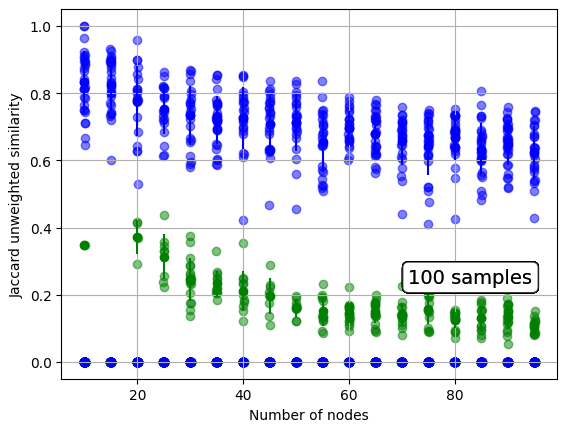

In [31]:
# Plot accuracy versus number of nodes with std deviation
dynamics_name = 'IsingGlauber'
folders = giom.list_directories(parent_dir= giom.base_dir)
M = 100

nodes = []
for graph in folders:
    metadata = giom.load_metadata(os.path.join(giom.base_dir, graph))
    nodes.append(metadata['nodes'])
nodes = np.array(nodes)
unique_nodes = np.unique(nodes)
nodes = unique_nodes

fig, ax = plt.subplots()

missing_times = [True, False]
color = ['green', 'blue']


for missing_times, color in zip(missing_times, color):
    for n in nodes:
        folders = giom.filter_graphs(nodes= n)
        jaccard = []
        for folder in folders:
            dyn_folder_path = os.path.join(giom.base_dir, folder, dynamics_name)
            inferred_folders = giom.list_directories(dyn_folder_path)
            for inferred_folder in inferred_folders:
                metadata = giom.load_metadata(os.path.join(dyn_folder_path, inferred_folder))
                if metadata['samples'] != M:
                    continue
                if metadata['missing_times'] == missing_times:
                    jaccard.append(metadata['jaccard_unweighted'])
        jaccard = np.array(jaccard)
        #ax.errorbar(n, mean, yerr=std, fmt='o', label=f'{n} nodes', color = "black")
        ax.scatter( np.random.uniform(n-0.1, n+0.1, len(jaccard)), jaccard, alpha=0.5, color = color)
        # Calulcate mean and std only when inference works
        jaccard = jaccard[jaccard != 0]
        if len(jaccard) > 0:
            mean = jaccard.mean()
            std = jaccard.std()
            ax.errorbar(n, mean, yerr=std, fmt='o', label=f'{n} nodes', color = color)
        else:
            ax.scatter(n, 0, color = color)

        ax.set_xlabel('Number of nodes')
        ax.set_ylabel('Jaccard unweighted similarity')
        ax.grid(True)

        # Insert a box with number of samples
        textstr = f'{M} samples'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.7, 0.3, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.savefig(os.path.join(giom.results_dir, f'jaccard_vs_nodes_{M}_samples.png'))
    

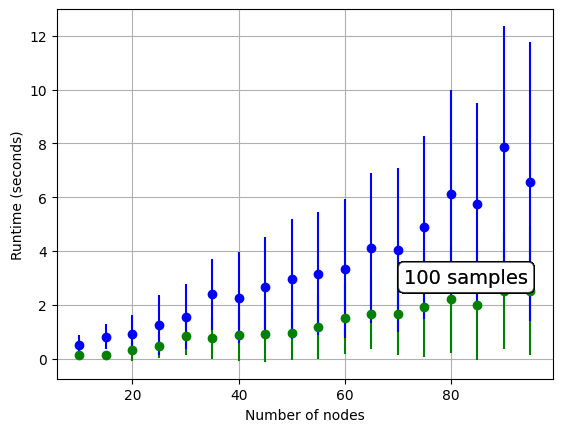

In [35]:
## Plot running time versus nodes with mean and std
dynamics_name = 'IsingGlauber'
folders = giom.list_directories(parent_dir= giom.base_dir)
M = 100

nodes = []
for graph in folders:
    metadata = giom.load_metadata(os.path.join(giom.base_dir, graph))
    nodes.append(metadata['nodes'])
nodes = np.array(nodes)
unique_nodes = np.unique(nodes)
nodes = unique_nodes

fig, ax = plt.subplots()
missing_times = [True, False]
color = ['green', 'blue']

for missing_times, color in zip(missing_times, color):
    for n in nodes:
        folders = giom.filter_graphs(nodes= n)
        runtime = []
        for folder in folders:
            dyn_folder_path = os.path.join(giom.base_dir, folder, dynamics_name)
            inferred_folders = giom.list_directories(dyn_folder_path)
            for inferred_folder in inferred_folders:
                metadata = giom.load_metadata(os.path.join(dyn_folder_path, inferred_folder))
                if metadata['samples'] != M:
                    continue
                if metadata['missing_times'] == missing_times:
                    runtime.append(metadata['runtime'])
        runtime = np.array(runtime)
        #ax.errorbar(n, mean, yerr=std, fmt='o', label=f'{n} nodes', color = "black")
        #ax.scatter( np.random.uniform(n-0.1, n+0.1, len(runtime)), runtime, alpha=0.5, color = color)
        # Calulcate mean and std only when inference works
        mean = runtime.mean()
        std = runtime.std()
        ax.errorbar(n, mean, yerr=std, fmt='o', label=f'{n} nodes', color = color)

        ax.set_xlabel('Number of nodes')
        ax.set_ylabel('Runtime (seconds)')
        ax.grid(True)

        # Insert a box with number of samples
        textstr = f'{M} samples'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.7, 0.3, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.savefig(os.path.join(giom.results_dir, f'runtime_vs_nodes_{M}_samples.png'))

## Visualize results

In [27]:
"""
Plot a visualization of the original graph and series of inferred graphs
"""

graph_folder = giom.filter_graphs(nodes= 30)[0]
dynamics_name = 'IsingGlauber'
if graph_folder:
    print(f"Selected graph folder: {graph_folder}")
    # Check which inferred graphs are available
    dyn_folder_path = os.path.join(giom.base_dir, graph_folder, dynamics_name)
    inferred_graphs = giom.list_directories(dyn_folder_path)
    dict = {}
    for inferred_graph in inferred_graphs:
        inferred_graph_path = os.path.join(dyn_folder_path, inferred_graph)
        metadata = giom.load_metadata(inferred_graph_path)
        dict[inferred_graph] = metadata['samples']
        print(f"Graph {inferred_graph} has {metadata['samples']} samples with unweighted accuracy {metadata['jaccard_unweighted']}")
# Sort dict keys by value (number of samples)
sorted_keys = sorted(dict, key=dict.get)
# Get sorted dict
dict = {k: dict[k] for k in sorted_keys}
print(dict)
print(dict.keys())
print(dict.values())

Selected graph folder: graph_23
{}
dict_keys([])
dict_values([])


In [ ]:


output_path = os.path.join(giom.results_dir, "sample_visualization_30_nodes.pdf")

# Get number of keys in dict
n_keys = len(dict)
# Make a figure with n_keys + 1 subplots
plt.switch_backend("cairo")
fig, ax = plt.subplots(1, n_keys + 1, figsize=(15, 5))
# Load original graph
graph_path = os.path.join(giom.base_dir, "graph_23", "graph.gt")
g = gt.load_graph(graph_path)
lay = gt.sfdp_layout(g)
gt.graph_draw(g, pos=lay, edge_color = 'black', vertex_color = 'black', vertex_fill_color = 'gray', mplfig = ax[0]).fit_view(yflip=True)
ax[0].set_title(f"True E = {g.num_edges()}")
# Load inferred graphs
for i, key in enumerate(dict.keys()):
    inferred_graph_path = os.path.join(dyn_folder_path, key, "graph.gt")
    u = gt.load_graph(inferred_graph_path)
    metadata = giom.load_metadata(os.path.join(dyn_folder_path, key))
    common_edges = [e for e in u.edges() if g.edge(e.source(), e.target())]
    edge_colors = u.new_edge_property("string")
    for e in u.edges():
        if e in common_edges:
            edge_colors[e] = "black"
        else:
            edge_colors[e] = "red"
    gt.graph_draw(u, pos=lay, mplfig=ax[i + 1], vertex_color = 'black', vertex_fill_color = 'gray', edge_color=edge_colors).fit_view(yflip=True)
    ax[i + 1].set_title(f"Infered M={dict[key]}, E= {metadata['edges']}, acc= {metadata['jaccard_unweighted']:0.2f}")

for a in ax:
    a.set_xticks([])  # Remove x ticks
    a.set_yticks([])  # Remove y ticks


fig.savefig(output_path, bbox_inches='tight')

In [5]:
"""
Create output csv file with the name given by variable 'filename'
with columns: nodes,true_edges,samples,inferred_edges,jaccard_unweighted,jaccard_weighted, runtime
"""
dynamics_name = 'IsingGlauber'
dynamics_regime = "eq" # alternative: "non_eq"

if dynamics_regime == "eq":
    inference_model_name = 'PseudoIsingBlockState' #class object used for inference
    folder_path = os.path.join(giom.experiment_name, "inference_results", "eq") # folder where output will be saved
    os.makedirs(folder_path, exist_ok= True)

if dynamics_regime == "non_eq":
    inference_model_name = 'IsingGlauberBlockState' #class object used for inference
    folder_path = os.path.join(giom.experiment_name, "inference_results", "eq") # folder where output will be saved
    os.makedirs(folder_path, exist_ok= True)

filename = "results.csv"
mode = 'w' #['a':'append', 'w': write']
insert_header = (mode == 'w')
# if mode == 'w', overwrite and insert heading.
# if mode == 'a', append to existing file. If does not exist, create new file but without heading.
file_path = os.path.join(folder_path, filename)


results = []
graph_folders = giom.list_directories(giom.base_dir)
for folder in graph_folders:

    nodes = 0
    true_edges = 0
    samples = 0
    inferred_edges = 0
    jaccard_unweighted = 0
    jaccard_weighted = 0
    runtime = 0

    dyn_folder_path = os.path.join(giom.base_dir, folder, dynamics_name)
    if os.path.isdir(dyn_folder_path) and os.path.exists(os.path.join(dyn_folder_path, 'dynamics.h5')):
        inferred_graph_dirs = [d for d in os.listdir(dyn_folder_path) if os.path.isdir(os.path.join(dyn_folder_path, d)) and d.startswith('inferred_graph')]
    
    if len(inferred_graph_dirs) == 0:
        continue

    # Load original graph metadata
    metadata = giom.load_metadata(dir= os.path.join(giom.base_dir, folder))
    nodes = metadata["nodes"]
    true_edges = metadata['edges']

    # Load inferred graph metadata
    for inferred_graph in inferred_graph_dirs:
        inferred_graph_path = os.path.join(dyn_folder_path, inferred_graph)
        try:
            metadata = giom.load_metadata(dir = inferred_graph_path)
            #try to get the entry at key 'model' and return 'unknown' if no such key is found
            model_name = metadata.get('model', 'unknown')
            inferred_edges = metadata['edges']
            samples = metadata['samples']
            jaccard_unweighted = metadata['jaccard_unweighted']
            jaccard_weighted = metadata['jaccard_weighted']
            runtime = metadata['runtime']
        except FileNotFoundError:
            print(f"Error: File metadata not found for {inferred_graph_path}")
        except KeyError as e:
            print(f"Error: Missing key {e} in metadata for {inferred_graph_path}")
        
        if model_name == inference_model_name:
            results.append({
                    'nodes': nodes,
                    'true_edges': true_edges,
                    'samples' : samples,
                    'inferred_edges' : inferred_edges,
                    'jaccard_unweighted' : jaccard_unweighted,
                    'jaccard_weighted' : jaccard_weighted,
                    'runtime': runtime
                    })
       
df = pd.DataFrame(results)
df.sort_values(by=['nodes', 'samples'], ascending=[True, True], inplace=True)
print(df.head())

with open(file_path, mode=mode, newline='') as f:
    df.to_csv(f, index=True, header= insert_header)

   nodes  true_edges  samples  inferred_edges  jaccard_unweighted  \
4     10          15      100               6            0.190476   
3     10          15      500              16            0.451613   
0     10          15     1000              16            0.516129   
5     10          15     2000              16            0.516129   
2     10          15     3000              17            0.562500   

   jaccard_weighted    runtime  
4          0.175238   0.411514  
3          0.342703   3.246917  
0          0.332775  10.309184  
5          0.328532  12.643773  
2          0.328643  17.062813  


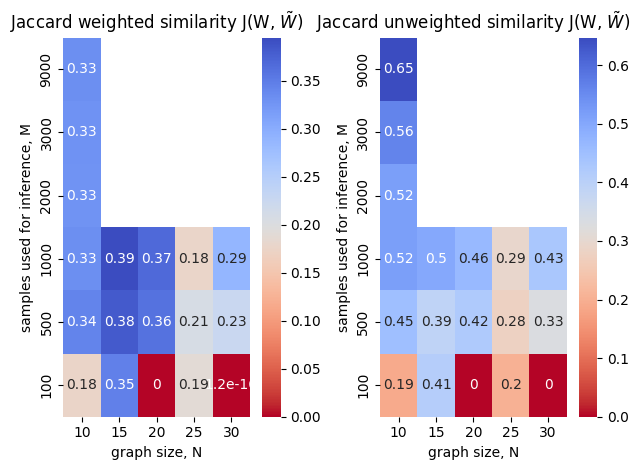

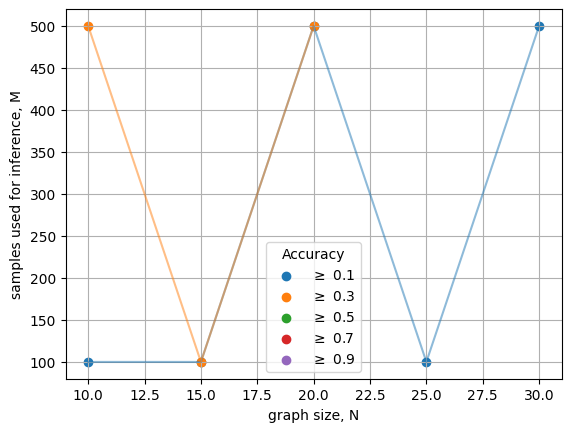

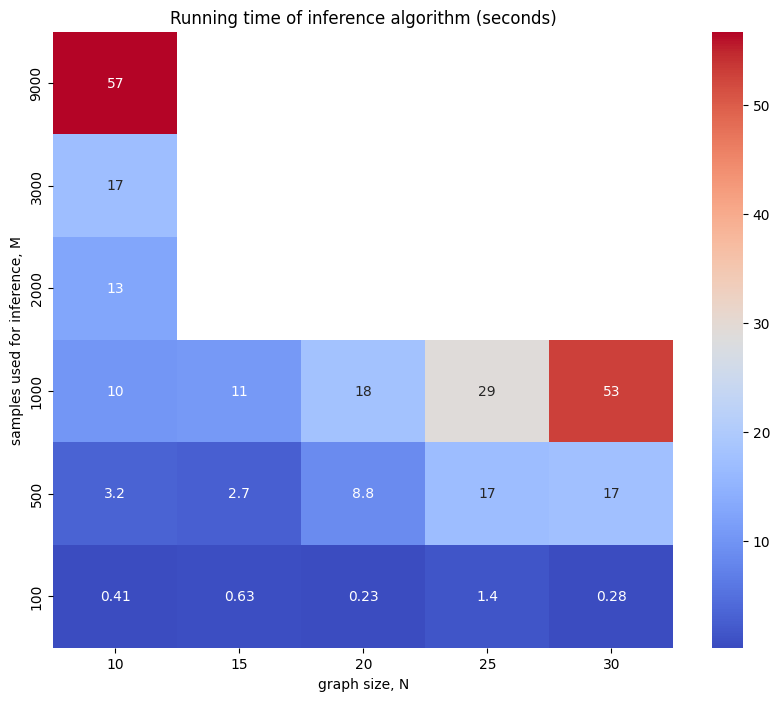

In [11]:
"""
Reads data from a CSV file (input_filename) and generates 3 visualizations:
Heatmap: Displays the Jaccard weighted similarity (accuracy) as a function of graph size (nodes)
        and sample size.
Multi-line Plot: Illustrates the minimum number of samples required to achieve specific accuracy levels across varying graph sizes. 
        For each accuracy threshold, the plot displays the minimum sample count for each graph size.

Both plots are saved as PDF files in the specified output paths.
"""

dynamics_regime = "eq" # alternative: "non_eq"
input_filename = 'results.csv'

heatmap_filename = 'heatmap.pdf'
multiline_filename = 'multiline.pdf'
time_filename = 'time.pdf'


if dynamics_regime == "eq":
    folder_path = os.path.join(giom.experiment_name, "inference_results", "eq") # folder containing input and output
    
if dynamics_regime == "non_eq":
    folder_path = os.path.join(giom.experiment_name, "inference_results", "non_eq") # folder containing input and output

# Read input file
df = pd.read_csv(os.path.join(folder_path, input_filename))


# Heatmap
fig, ax = plt.subplots(nrows=1, ncols=2)
# weighted similarity
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='jaccard_weighted', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", cbar=True, ax = ax[0])
ax[0].set_title(r'Jaccard weighted similarity J(W, $\tilde{W}$)')
ax[0].set_xlabel('graph size, N')
ax[0].set_ylabel('samples used for inference, M')
ax[0].invert_yaxis()
# unweighted similarity
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='jaccard_unweighted', aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", cbar=True, ax = ax[1])
ax[1].set_title(r'Jaccard unweighted similarity J(W, $\tilde{W}$)')
ax[1].set_xlabel('graph size, N')
ax[1].set_ylabel('samples used for inference, M')
ax[1].invert_yaxis()
plt.savefig(os.path.join(folder_path, heatmap_filename))
plt.tight_layout()

# Multiline
accuracy_levels = [0.1* c for c in range(1, 10, 2)]
fig, ax = plt.subplots()
for acc in accuracy_levels:
    temp = df[df['jaccard_weighted'] >= acc]
    grouped_data = temp.groupby('nodes', as_index=False)['samples'].min()
    ax.scatter(grouped_data['nodes'], grouped_data['samples'], label= rf"$\geq$ {acc:.1f}")
    ax.plot(grouped_data['nodes'], grouped_data['samples'], alpha = 0.5)
ax.set_xlabel('graph size, N')
ax.set_ylabel('samples used for inference, M')
ax.grid()
plt.legend(title= "Accuracy")
plt.savefig(os.path.join(folder_path, multiline_filename))

# Time heatmap
heatmap_data = df.pivot_table(index='samples', columns='nodes', values='runtime', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True)
plt.gca().invert_yaxis()
plt.title(r'Running time of inference algorithm (seconds)')
plt.xlabel('graph size, N')
plt.ylabel('samples used for inference, M')
plt.savefig(os.path.join(folder_path, time_filename))


In [11]:
# Filter graphs created on a specific date
date = "2024-09-30"

graphs = giom.filter_graphs(nodes= None, creation_date= date)

[]


: 